In [11]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from joblib import Parallel, delayed

In [12]:
def sample_df_from_population(n_samples,n_cov,b_d1=1/2):
    """
    Defines linear data generating process for y, covariates (cov_i), and effect size,
    y=beta_0+beta_1*cov_1+beta_2*cov_2+...+beta_i*cov_i+b_d1*d
    
    """
    res_dict={}
    covs=np.asarray([np.random.rand(n_samples) for i in range(n_cov)])
    d=np.array([0] * int(n_samples / 2) + [1] * int(n_samples / 2))
    const=np.asarray([1 for i in range(n_samples)])
    y=covs.sum(axis=0)+const+np.random.rand(n_samples)+3*np.random.rand(n_samples)+1*np.random.rand(n_samples)
    y+=b_d1*d
    res_dict={**{f"covs_{i}":covs[i] for i in range(covs.shape[0])},**{"d":d},**{"const":const},**{"y":y}}
    return pd.DataFrame(res_dict),b_d1

In [13]:
n_samples=1000
sample_df,true_effect=sample_df_from_population(n_samples,b_d1=1/2,n_cov=50)
print(true_effect/sample_df['y'].mean())
true_effect

0.017393563050868914


0.5

In [25]:
# sample_df['y']

In [15]:
def get_estimates(i,n_samples,effect,n_cov):
    """
    Function to get estimates of effect based on seveal approach:
    1. Effect CUPED - fit metric to covariates, extract fitted values and  then estimate effect on residuals
    2. Effect Linear Regression -  fit linear regression model with covariates and effect
    3. Effect w/o var reduction - calculate effect without any variance reduction techniques
    """
    res_dict={}
    sample_df,true_effect=sample_df_from_population(n_samples,b_d1=effect,n_cov=n_cov)
    y=sample_df['y']
    X_cov=sample_df.drop(["y","d"],axis=1)
    
    #Cuped
    y_hat=LinearRegression().fit(X_cov, y).predict(X_cov)
    sample_df['y_cuped']=y.values-y_hat
    effect=sample_df[['y_cuped','d']].groupby('d').mean().apply(lambda x:x[1]-x[0])[0]
    res_dict['Effect CUPED']=effect
    sample_df=sample_df.drop("y_cuped",axis=1)
    
    #Cuped with fit on control only
    y_control=sample_df.query("d==0")['y']
    X_cov_control=sample_df.query("d==0").drop(["y","d"],axis=1)
    y_hat=LinearRegression().fit(X_cov_control, y_control).predict(X_cov)
    sample_df['y_cuped']=y.values-y_hat
    effect=sample_df[['y_cuped','d']].groupby('d').mean().apply(lambda x:x[1]-x[0])[0]
    res_dict['Effect CUPED fit control only']=effect
    sample_df=sample_df.drop("y_cuped",axis=1)

    #Linear regression
    effect_linreg=sm.OLS(y, sample_df.drop("y",axis=1)).fit().params['d']
    res_dict['Effect Linear Regression']=effect_linreg
    
    #W/o variance reduction
    res_dict['Effect w/o var reduction']=sample_df[['y','d']].groupby('d').mean().apply(lambda x:x[1]-x[0])[0]
    res_dict['True effect']=true_effect

    return res_dict

In [16]:
def plot_hist(res,true_effect):
    """
    Plots sampling distribution of several effect calculation approaches
    """
    effects_df=pd.DataFrame(res)
    mean_effect=effects_df["True effect"].mean()
    print(f"True effect: {mean_effect :.3f}")
    effects_df=effects_df.drop("True effect",axis=1)
    df2 = pd.melt(effects_df, value_name="Effect",var_name="Effect type")
    plt.figure(figsize=(10, 5))
    for effect_type in df2['Effect type'].unique():
        mean_estimated_effect=df2[df2['Effect type']==effect_type]['Effect'].mean()
        g=sns.distplot(df2[df2['Effect type']==effect_type]['Effect'],  label=f"{effect_type}")
        g.set_title("Sampling distributions of effects")
        print(f"{effect_type}: {mean_estimated_effect:.3f}")
    g.axvline(x=true_effect,linewidth=2,label="True effect",color="black")
    g.legend()

In [17]:
def print_bias(res):
    means=pd.DataFrame(res).mean().drop("Effect %")
    print(f"Estimated bias in % from true population parameter")
    print((means-effect)/effect*100)

In [18]:
sample_size=1000
number_of_samples=5000
effect=0.5
n_cov=1
res=Parallel(n_jobs=8)(delayed(get_estimates)(i,sample_size,effect,n_cov) for i in range(number_of_samples))
sample_df,true_effect=sample_df_from_population(number_of_samples,b_d1=effect,n_cov=n_cov)

True effect in % to control 12.45 %
True effect: 0.500
Effect CUPED: 0.499
Effect CUPED fit control only: 0.500
Effect Linear Regression: 0.500
Effect w/o var reduction: 0.500
Number of covariates: 1


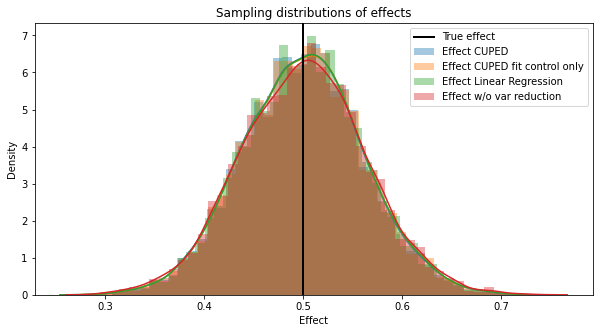

In [19]:
effect_as_ration_to_mean=true_effect/sample_df.query("d==0")['y'].mean()
print(f"True effect in % to control {effect_as_ration_to_mean*100:.2f} %")
plot_hist(res,effect)
print(f"Number of covariates: {n_cov}")

True effect in % to control 8.35 %
True effect: 0.500
Effect CUPED: 0.497
Effect CUPED fit control only: 0.500
Effect Linear Regression: 0.500
Effect w/o var reduction: 0.499
Number of covariates: 5


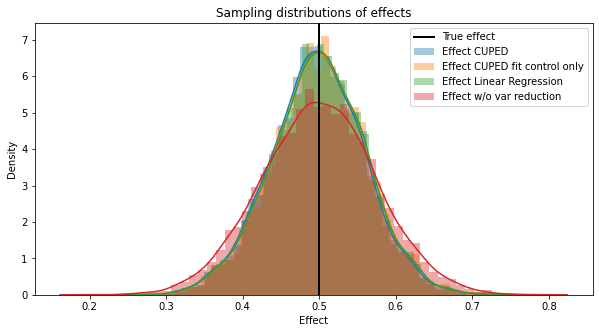

In [20]:
sample_size=1000
number_of_samples=5000
effect=0.5
n_cov=5
res=Parallel(n_jobs=8)(delayed(get_estimates)(i,sample_size,effect,n_cov) for i in range(number_of_samples))
sample_df,true_effect=sample_df_from_population(number_of_samples,b_d1=effect,n_cov=n_cov)
effect_as_ration_to_mean=true_effect/sample_df.query("d==0")['y'].mean()
print(f"True effect in % to control {effect_as_ration_to_mean*100:.2f} %")
plot_hist(res,effect)
print(f"Number of covariates: {n_cov}")

True effect in % to control 5.87 %
True effect: 0.500
Effect CUPED: 0.495
Effect CUPED fit control only: 0.500
Effect Linear Regression: 0.500
Effect w/o var reduction: 0.499
Number of covariates: 10


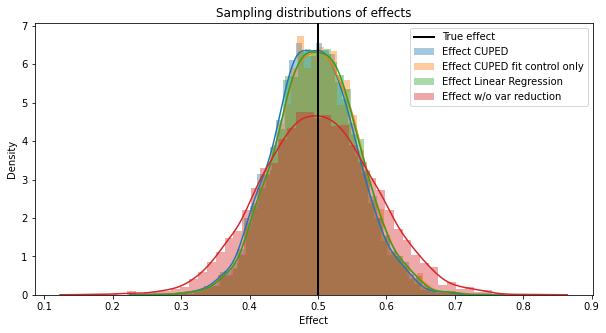

In [21]:
sample_size=1000
number_of_samples=5000
effect=0.5
n_cov=10
res=Parallel(n_jobs=8)(delayed(get_estimates)(i,sample_size,effect,n_cov) for i in range(number_of_samples))
sample_df,true_effect=sample_df_from_population(number_of_samples,b_d1=effect,n_cov=n_cov)
effect_as_ration_to_mean=true_effect/sample_df.query("d==0")['y'].mean()
print(f"True effect in % to control {effect_as_ration_to_mean*100:.2f} %")
plot_hist(res,effect)
print(f"Number of covariates: {n_cov}")

True effect in % to control 1.75 %
True effect: 0.500
Effect CUPED: 0.476
Effect CUPED fit control only: 0.501
Effect Linear Regression: 0.501
Effect w/o var reduction: 0.499
Number of covariates: 50


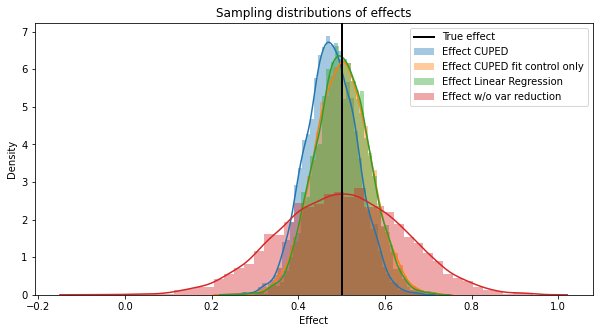

In [22]:
sample_size=1000
number_of_samples=5000
effect=0.5
n_cov=50
res=Parallel(n_jobs=8)(delayed(get_estimates)(i,sample_size,effect,n_cov) for i in range(number_of_samples))
sample_df,true_effect=sample_df_from_population(number_of_samples,b_d1=effect,n_cov=n_cov)
effect_as_ration_to_mean=true_effect/sample_df.query("d==0")['y'].mean()
print(f"True effect in % to control {effect_as_ration_to_mean*100:.2f} %")
plot_hist(res,effect)
print(f"Number of covariates: {n_cov}")

True effect in % to control 0.94 %
True effect: 0.500
Effect CUPED: 0.450
Effect CUPED fit control only: 0.500
Effect Linear Regression: 0.500
Effect w/o var reduction: 0.492
Number of covariates: 100


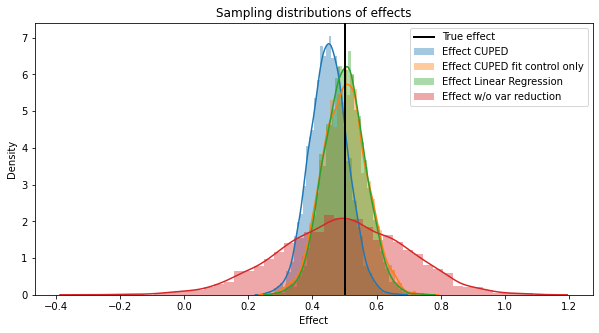

In [23]:
sample_size=1000
number_of_samples=5000
effect=0.5
n_cov=100
res=Parallel(n_jobs=8)(delayed(get_estimates)(i,sample_size,effect,n_cov) for i in range(number_of_samples))
sample_df,true_effect=sample_df_from_population(number_of_samples,b_d1=effect,n_cov=n_cov)
effect_as_ration_to_mean=true_effect/sample_df.query("d==0")['y'].mean()
print(f"True effect in % to control {effect_as_ration_to_mean*100:.2f} %")
plot_hist(res,effect)
print(f"Number of covariates: {n_cov}")

True effect in % to control 9.34 %
True effect: 5.000
Effect CUPED: 4.497
Effect CUPED fit control only: 4.999
Effect Linear Regression: 4.999
Effect w/o var reduction: 4.995
Number of covariates: 100


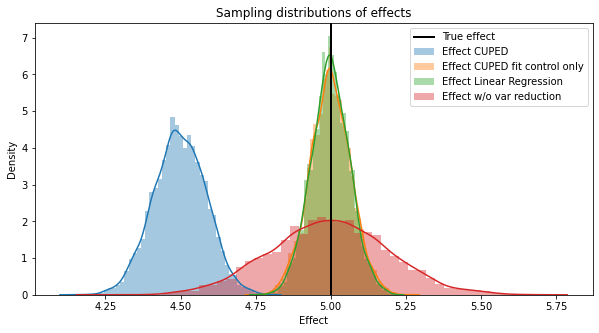

In [24]:
sample_size=1000
number_of_samples=5000
effect=5
n_cov=100
res=Parallel(n_jobs=8)(delayed(get_estimates)(i,sample_size,effect,n_cov) for i in range(number_of_samples))
sample_df,true_effect=sample_df_from_population(number_of_samples,b_d1=effect,n_cov=n_cov)
effect_as_ration_to_mean=true_effect/sample_df.query("d==0")['y'].mean()
print(f"True effect in % to control {effect_as_ration_to_mean*100:.2f} %")
plot_hist(res,effect)
print(f"Number of covariates: {n_cov}")

### Is biased caused by overfitting?
No ( because if each sample size is  10 000, then all factors are significant and bias still exists)

In [22]:
sample_df=sample_df_from_population(n_samples,b_d1=effect,n_cov=n_cov)
y=sample_df['y']
X_cov=sample_df.drop(["y","d"],axis=1)

mod = sm.OLS(y,X_cov)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     895.6
Date:                Sun, 04 Apr 2021   Prob (F-statistic):               0.00
Time:                        21:24:28   Log-Likelihood:                -17356.
No. Observations:               10000   AIC:                         3.491e+04
Df Residuals:                    9899   BIC:                         3.564e+04
Df Model:                         100                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
covs_0         1.2953      0.186      6.967      0.0